In [1]:
import jax
import jax.numpy as jnp
import numpy as np # get rid of this eventually
import argparse
from jax import jit
from jax.experimental.ode import odeint
from functools import partial # reduces arguments to function by making some subset implicit

from jax.example_libraries import stax
from jax.example_libraries import optimizers

import os, sys, time
sys.path.append('..')

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
sys.path.append('../experiment_trap/')

from lnn import lagrangian_eom_rk4, lagrangian_eom, unconstrained_eom, raw_lagrangian_eom
from models import mlp as make_mlp


In [4]:
sys.path.append('../hyperopt_trap')
from HyperparameterSearch import learned_dynamics
from HyperparameterSearch import extended_mlp

In [5]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

In [6]:
from data import get_trajectory
from data import get_trajectory_analytic
from physics_trap import analytical_fn

vfnc = jax.jit(jax.vmap(analytical_fn))
vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxsteps=100), (0, None), 0))

### Now, let's load the best model. To generate more models, see the code below.

In [7]:
import pickle as pkl

In [8]:
args = ObjectView({'dataset_size': 1,
                 'fps': 1000,
                 'samples': 2,
                 'num_epochs': 80000,
                 'seed': 0,
                 'loss': 'l1',
                 'act': 'softplus',
                 'hidden_dim': 600,
                 'output_dim': 1,
                 'layers': 4,
                 'n_updates': 1,
                 'lr': 0.001,
                 'lr2': 2e-05,
                 'dt': 0.001,
                 'model': 'gln',
                 'batch_size': 512,
                 'l2reg': 5.7e-07,
                })

rng = jax.random.PRNGKey(args.seed)

In [9]:
from jax.experimental.ode import odeint
from HyperparameterSearch import new_get_dataset
from matplotlib import pyplot as plt

In [10]:
vfnc = jax.jit(jax.vmap(analytical_fn, 0, 0))
vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxsteps=100), (0, None), 0))
minibatch_per = 2000
batch = 512

@jax.jit
def get_derivative_dataset(rng):
    # randomly sample inputs
    y0 = jnp.concatenate([
        (jax.random.uniform(rng, (batch*minibatch_per, 3)))*1e-2,
        (jax.random.uniform(rng+1, (batch*minibatch_per, 3)))*1e-3
    ], axis=1)
    
    return y0, vfnc(y0)

In [11]:
best_params = None
best_loss = np.inf

In [12]:
from itertools import product

In [13]:
import HyperparameterSearch
from jax.tree_util import tree_flatten
from HyperparameterSearch import make_loss, train
from copy import deepcopy as copy
from jax.tree_util import tree_flatten

init_random_params, nn_forward_fn = extended_mlp(args)
HyperparameterSearch.nn_forward_fn = nn_forward_fn
_, init_params = init_random_params(rng+1, (-1, 6))
rng += 1
model = (nn_forward_fn, init_params)
opt_init, opt_update, get_params = optimizers.adam(args.lr)
opt_state = opt_init([[l2/200.0 for l2 in l1] for l1 in init_params])

@jax.jit
def loss(params, batch, l2reg):
    state, targets = batch#_rk4
    leaves, _ = tree_flatten(params)
    l2_norm = sum(jnp.vdot(param, param) for param in leaves)
    preds = jax.vmap(partial(raw_lagrangian_eom,learned_dynamics(params)))(state)
    return jnp.sum(jnp.abs(preds - targets)) + l2reg*l2_norm/args.batch_size

@jax.jit
def update_derivative(i, opt_state, batch, l2reg):
    params = get_params(opt_state)
    param_update = jax.grad(lambda *args: loss(*args)/len(batch), 0)(params, batch, l2reg)
    params = get_params(opt_state)
    return opt_update(i, param_update, opt_state), params


best_small_loss = np.inf
(nn_forward_fn, init_params) = model
iteration = 0
total_epochs = 300
minibatch_per = 2000
train_losses, test_losses = [], []

lr = 1e-5 #1e-3

import math
final_div_factor=1e4

#OneCycleLR:
@jax.jit
def OneCycleLR(pct):
    #Rush it:
    start = 0.2 #0.2
    pct = pct * (1-start) + start
    high, low = lr, lr/final_div_factor
    scale = 1.0 - (jnp.cos(2 * jnp.pi * pct) + 1)/2
    return low + (high - low)*scale
    
from lnn import custom_init
opt_init, opt_update, get_params = optimizers.adam( OneCycleLR )
init_params = custom_init(init_params, seed=0)

opt_state = opt_init(init_params)
bad_iterations = 0
print(lr)

1e-05


Idea: add identity before inverse:

# Let's train it:

In [14]:
rng = jax.random.PRNGKey(0)

In [15]:
epoch = 0

In [16]:
batch_data = get_derivative_dataset(rng)[0][:1000], get_derivative_dataset(rng)[1][:1000]

In [17]:
batch_data[0].shape

(1000, 6)

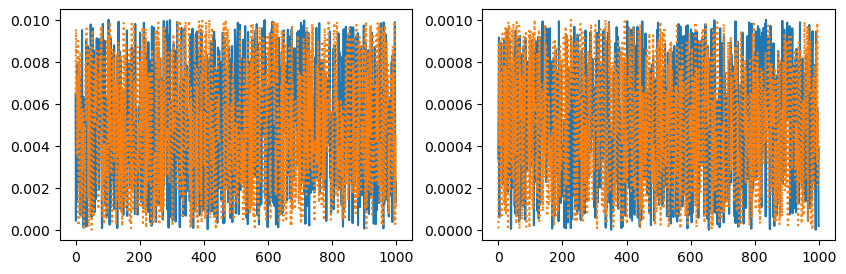

In [18]:
fig = plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.plot(batch_data[0][:,2]); plt.plot(batch_data[0][:,1], ':')
plt.subplot(1,2,2); plt.plot(batch_data[1][:,0]); plt.plot(batch_data[1][:,1], ':')

In [19]:
loss(get_params(opt_state), batch_data, 0.0)/len(batch_data[0])

Array(25.329798, dtype=float32)

In [20]:
opt_state, params = update_derivative(0.0, opt_state, batch_data, 0.0)

In [21]:
from tqdm.notebook import tqdm

In [22]:
for epoch in tqdm(range(epoch, total_epochs)):
    epoch_loss = 0.0
    num_samples = 0
    all_batch_data = get_derivative_dataset(rng)
    for minibatch in range(minibatch_per):
        fraction = (epoch + minibatch/minibatch_per)/total_epochs
        batch_data = (all_batch_data[0][minibatch*batch:(minibatch+1)*batch], all_batch_data[1][minibatch*batch:(minibatch+1)*batch])
        rng += 10
        opt_state, params = update_derivative(fraction, opt_state, batch_data, 1e-6)
        cur_loss = loss(params, batch_data, 0.0)
        epoch_loss += cur_loss
        num_samples += batch
    closs = epoch_loss/num_samples
    print('epoch={} lr={} loss={}'.format(epoch, OneCycleLR(fraction), closs) )
    if closs < best_loss:
        best_loss = closs
        best_params = [[copy(jax.device_get(l2)) for l2 in l1] if len(l1) > 0 else () for l1 in params]

  0%|          | 0/300 [00:00<?, ?it/s]

epoch=0 lr=3.53541008735192e-06 loss=0.570883572101593
epoch=1 lr=3.6157020986138377e-06 loss=0.5060519576072693
epoch=2 lr=3.6963824641134124e-06 loss=0.5062404870986938
epoch=3 lr=3.7774289012304507e-06 loss=0.5055466294288635
epoch=4 lr=3.858819127344759e-06 loss=0.5058241486549377
epoch=5 lr=3.940529040846741e-06 loss=0.5051432251930237
epoch=6 lr=4.022538178105606e-06 loss=0.5046956539154053
epoch=7 lr=4.104820163775003e-06 loss=0.5044769644737244
epoch=8 lr=4.187354534224141e-06 loss=0.5047396421432495
epoch=9 lr=4.270117187843425e-06 loss=0.5040227174758911
epoch=10 lr=4.353084477770608e-06 loss=0.5042288303375244
epoch=11 lr=4.436233666638145e-06 loss=0.5037609934806824
epoch=12 lr=4.51954065283644e-06 loss=0.5038599371910095
epoch=13 lr=4.60298360849265e-06 loss=0.5037159323692322
epoch=14 lr=4.6865370677551255e-06 loss=0.5038110613822937
epoch=15 lr=4.770179657498375e-06 loss=0.5032897591590881
epoch=16 lr=4.85388682136545e-06 loss=0.5040255188941956
epoch=17 lr=4.93763491249

epoch=141 lr=9.401639545103535e-06 loss=0.4490512013435364
epoch=142 lr=9.361284355691168e-06 loss=0.4486631751060486
epoch=143 lr=9.319706805399619e-06 loss=0.44795361161231995
epoch=144 lr=9.276915989175905e-06 loss=0.4479515850543976
epoch=145 lr=9.232923730451148e-06 loss=0.44840264320373535
epoch=146 lr=9.187744581140578e-06 loss=0.4468269944190979
epoch=147 lr=9.141389455180615e-06 loss=0.4468618929386139
epoch=148 lr=9.093871994991787e-06 loss=0.44755473732948303
epoch=149 lr=9.04520584299462e-06 loss=0.44526976346969604
epoch=150 lr=8.995402822620235e-06 loss=0.4460875391960144
epoch=151 lr=8.944479304773267e-06 loss=0.44547608494758606
epoch=152 lr=8.892448931874242e-06 loss=0.44610607624053955
epoch=153 lr=8.839325346343685e-06 loss=0.4455645680427551
epoch=154 lr=8.78512582858093e-06 loss=0.44493070244789124
epoch=155 lr=8.7298612925224e-06 loss=0.4440775215625763
epoch=156 lr=8.67354992806213e-06 loss=0.4439840316772461
epoch=157 lr=8.616209015599452e-06 loss=0.443853020668

epoch=279 lr=2.791041424643481e-07 loss=0.4174114465713501
epoch=280 lr=2.522191664411366e-07 loss=0.4172367751598358
epoch=281 lr=2.2666685595140734e-07 loss=0.4175073504447937
epoch=282 lr=2.0245548171260452e-07 loss=0.416864812374115
epoch=283 lr=1.795898469936219e-07 loss=0.41641268134117126
epoch=284 lr=1.580782935661773e-07 loss=0.4165585935115814
epoch=285 lr=1.3792678998925112e-07 loss=0.4164678156375885
epoch=286 lr=1.1914008979374557e-07 loss=0.41588452458381653
epoch=287 lr=1.0172296782684498e-07 loss=0.416503369808197
epoch=288 lr=8.568138554210236e-08 loss=0.4163413941860199
epoch=289 lr=7.10189169694786e-08 loss=0.41569921374320984
epoch=290 lr=5.774152356252671e-08 loss=0.41544008255004883
epoch=291 lr=4.5851585639411496e-08 loss=0.4157322347164154
epoch=292 lr=3.535149062372511e-08 loss=0.4154908061027527
epoch=293 lr=2.624600270451083e-08 loss=0.41546085476875305
epoch=294 lr=1.85375093053608e-08 loss=0.4154317080974579
epoch=295 lr=1.2227200585357423e-08 loss=0.415679

Look at distribution of weights to make a better model?

In [23]:
pkl.dump( best_params, open('penning_trap_params.pt', 'wb') )

# best_params = pkl.load(open('penning_trap_params.pt', 'rb'))

In [24]:
# opt_state = opt_init(best_params)

### Make sure the args are the same:

The seed: [8, 8] looks pretty good! Set args.n_updates=3.

In [25]:
# rng+7
max_t = 1
new_dataset = new_get_dataset(jax.random.PRNGKey(2),
                              t_span=[0, max_t],
                              fps=1000, test_split=1.0,
                              unlimited_steps=False)


In [26]:
new_dataset['x'].shape

(99, 6)

In [27]:
t = new_dataset['x'][0, :]
tall = [jax.device_get(t)]
p = get_params(opt_state)

In [28]:
pred_tall = jax.device_get(odeint(
    partial(raw_lagrangian_eom, learned_dynamics(p)),
    t,
    np.linspace(0, max_t, num=new_dataset['x'].shape[0]),
    mxstep=100))

In [29]:
@jit
def kinetic_energy(state, m=1, wc=100, wz=10):
    x1, x2, x3, y1, y2, y3 = state
    T = 0.5 * (y1**2 + y2**2 + y3**2)
    return T

@jit
def potential_energy(state, m=1, wc=100, wz=10):
    x1, x2, x3, y1, y2, y3 = state
    V = 0.25 * wz**2 * (x1**2 + x2**2 - 2*x3**2) + 0.5 * wc * (x1*y2 - y1*x2)
    return V 

### Let's compare energy for a variety of initial conditions:

In [80]:
import utils_data_2

In [81]:
""" System of Penning-Trap """

iparam = [0.5*199.9434, np.sqrt(2*49.9995)]
param = [100, 10]

samples = 25
x0 = jnp.concatenate([
        jax.random.uniform(rng, (samples, 3), minval=1e-3, maxval=1e-2),
        jax.random.uniform(rng+1, (samples, 3), minval=1e-3, maxval=1e-2)
    ], axis=1)

In [82]:
all_errors_LNN = []
all_errors_Bayes = []
store_error_LNN = []
store_error_Bayes = []
Pred_LNN = []
Pred_Bayes = []
Response = []

for i in tqdm(range(samples)):
    max_t = 1
    fps = 1000
    
    t = x0[i,:]
    tparam = [1/fps, 0, max_t]
    dummy, _ = utils_data_2.penning_trap(t, param, tparam)
    
    new_dataset = np.zeros([dummy.shape[0], dummy.shape[1]])
    
    new_dataset[0,:] = dummy[0,:]
    new_dataset[1,:] = dummy[2,:]
    new_dataset[2,:] = dummy[4,:]
    new_dataset[3,:] = dummy[1,:]
    new_dataset[4,:] = dummy[3,:]
    new_dataset[5,:] = dummy[5,:]

    tall = [jax.device_get(t)]
    p = best_params
    pred_tall = jax.device_get(odeint(
        partial(raw_lagrangian_eom, learned_dynamics(p)),t,np.linspace(0, max_t, num=fps), mxstep=100))
    
    tparam = [1/fps, 0, max_t]
    dummy, t_eval_3dof_i = utils_data_2.penning_trap(t, iparam, tparam)
    
    xt_3dof_i = np.zeros([dummy.shape[0], dummy.shape[1]])
    
    xt_3dof_i[0,:] = dummy[0,:]
    xt_3dof_i[1,:] = dummy[2,:]
    xt_3dof_i[2,:] = dummy[4,:]
    xt_3dof_i[3,:] = dummy[1,:]
    xt_3dof_i[4,:] = dummy[3,:]
    xt_3dof_i[5,:] = dummy[5,:]
    
    total_true_energy = (
        jax.vmap(kinetic_energy, 0, 0)(new_dataset.T) + \
        jax.vmap(potential_energy, 0, 0)(new_dataset.T)
    ) 
    total_predicted_energy = (
        jax.vmap(kinetic_energy, 0, 0)(pred_tall[:]) + \
        jax.vmap(potential_energy, 0, 0)(pred_tall[:])
    )
    total_proposed_energy = (
    jax.vmap(kinetic_energy, 0, 0)(xt_3dof_i.T) + \
    jax.vmap(potential_energy, 0, 0)(xt_3dof_i.T)
    )

    store_error_LNN.append(jnp.abs(total_predicted_energy-total_true_energy)/total_true_energy)
    store_error_Bayes.append(jnp.abs(total_proposed_energy-total_true_energy)/total_true_energy)
    
    cur_error_1 = np.linalg.norm(total_predicted_energy-total_true_energy)/np.linalg.norm(total_true_energy)
    cur_error_2 = np.linalg.norm(total_proposed_energy-total_true_energy)/np.linalg.norm(total_true_energy)
    
    all_errors_LNN.append(cur_error_1)
    all_errors_Bayes.append(cur_error_2)
    
    Pred_LNN.append( total_predicted_energy )
    Pred_Bayes.append( total_proposed_energy )
    Response.append( total_true_energy )
    print(i, '--LNN error--', jnp.average(jnp.array(all_errors_LNN)),
          'Bayes error', jnp.average(jnp.array(all_errors_Bayes)))

  0%|          | 0/25 [00:00<?, ?it/s]

0 --LNN error-- 71525.38 Bayes error 0.015523395
1 --LNN error-- 49849.895 Bayes error 0.015643701
2 --LNN error-- 36171.895 Bayes error 0.014687842
3 --LNN error-- 33964.57 Bayes error 0.015063458
4 --LNN error-- 31352.957 Bayes error 0.015127897
5 --LNN error-- 28088.787 Bayes error 0.014812517
6 --LNN error-- 27896.666 Bayes error 0.015021546
7 --LNN error-- 27965.715 Bayes error 0.014116949
8 --LNN error-- 26259.094 Bayes error 0.014387093
9 --LNN error-- 29729.303 Bayes error 0.013858728
10 --LNN error-- 28223.115 Bayes error 0.0137088895
11 --LNN error-- 29130.922 Bayes error 0.013894275
12 --LNN error-- 28717.92 Bayes error 0.013547084
13 --LNN error-- 28411.395 Bayes error 0.013690614
14 --LNN error-- 27720.754 Bayes error 0.013895704
15 --LNN error-- 27391.795 Bayes error 0.0140313115
16 --LNN error-- 26556.236 Bayes error 0.013638993
17 --LNN error-- 25844.688 Bayes error 0.013801721
18 --LNN error-- 25251.672 Bayes error 0.013960685
19 --LNN error-- 24424.72 Bayes error 0.01

In [83]:
Pred_LNN = np.array( Pred_LNN )
Pred_Bayes = np.array( Pred_Bayes )
Response = np.array( Response )

print(Pred_LNN.shape, Pred_Bayes.shape, Response.shape)

(25, 1000) (25, 1000) (25, 1000)


In [84]:
# shape = Pred_LNN.shape[1]
# target = np.arange(0, max_t, shape)
# corrected_LNN = np.zeros_like(Pred_LNN)

# for i in range(25):
#     if np.isnan(Pred_LNN[i, :]).any():
#         non_nan_values = Pred_LNN[i, np.where( np.isnan(Pred_LNN[i,:]) == False )[0]]
#         min_v = np.min(non_nan_values)
#         max_v = np.max(non_nan_values)
        
#         xp = np.linspace(0, max_t, len(non_nan_values))
#         yp = np.interp(target, xp, non_nan_values)
#         corrected_LNN[i, ...] = yp
        
#         print('Sample-{}'.format(i))
    

In [85]:
print('L2 error: LNN--, Proposed--', 100*np.mean(cur_error_1), 100*np.mean(cur_error_2))

L2 error: LNN--, Proposed-- 3368283.984375 0.8673880249261856


In [86]:
plt.rc('font', family='serif')
plt.rc('font', size=12)


## Plots made down here:

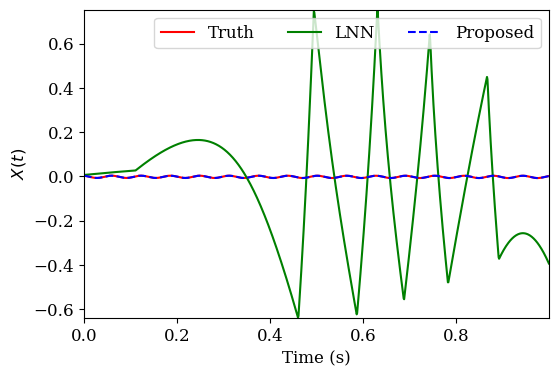

In [87]:
fig2 = plt.figure(figsize=(6,4))
plt.plot(t_eval_3dof_i, new_dataset[4, :], 'r', label='Truth')
plt.plot(t_eval_3dof_i, pred_tall[:, 4], color='green', label='LNN')
plt.plot(t_eval_3dof_i, xt_3dof_i[4,:], '--b', label='Proposed')
plt.ylabel(r'$X(t)$')
plt.xlabel('Time (s)')
plt.legend(ncol=3, loc=1)
plt.margins(0)

## Perform comparison with proposed Bayesian algorithm:

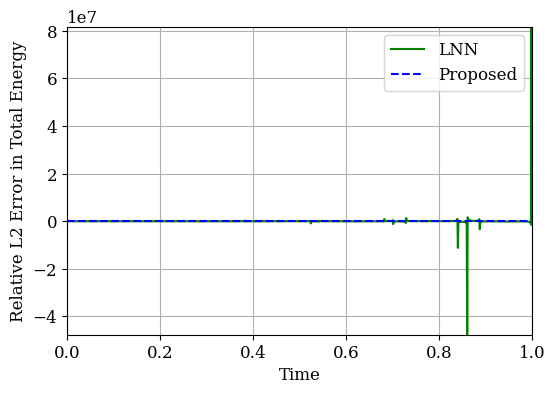

In [88]:
total_true_energy = (
    jax.vmap(kinetic_energy, 0, 0)(new_dataset.T) + \
    jax.vmap(potential_energy, 0, 0)(new_dataset.T)
)
total_predicted_energy = (
    jax.vmap(kinetic_energy, 0, 0)(pred_tall[:]) + \
    jax.vmap(potential_energy, 0, 0)(pred_tall[:])
)
total_proposed_energy = (
    jax.vmap(kinetic_energy, 0, 0)(xt_3dof_i.T) + \
    jax.vmap(potential_energy, 0, 0)(xt_3dof_i.T)
)

fig3 = plt.figure(figsize=(6,4))
plt.plot( np.linspace(0, max_t, fps), jnp.abs(total_predicted_energy-total_true_energy)/total_true_energy, 
        'g' , label='LNN' )
plt.plot( t_eval_3dof_i, jnp.abs(total_proposed_energy-total_true_energy)/total_true_energy,
        '--b', label='Proposed' )

plt.ylabel('Relative L2 Error in Total Energy')
plt.xlabel('Time')
# plt.yscale('log')
plt.legend()
plt.margins(0)
plt.grid(True)

In [89]:
# Pred_LNN = np.array( Pred_LNN )
# Pred_Bayes = np.array( Pred_Bayes )
# Response = np.array( Response )

error_LNN = np.abs(Pred_LNN - Response)/np.abs(Response)
error_Bayes = np.abs(Pred_Bayes - Response)/np.abs(Response)

mean_LNN = np.mean(error_LNN, axis = 0)
std_LNN = np.std(error_LNN, axis = 0)

mean_Bayes = np.mean(error_Bayes, axis = 0)
std_Bayes = np.std(error_Bayes, axis = 0)


In [90]:
plt.rc('font', size=36)

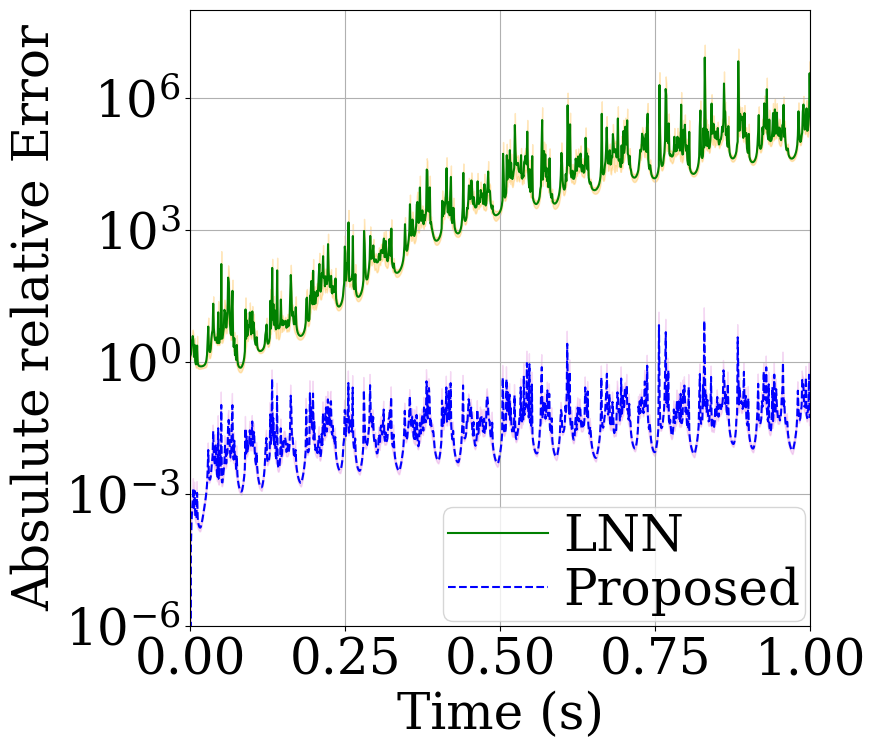

In [91]:
fig4 = plt.figure(figsize=(8,8))
plt.plot( np.linspace(0, max_t, fps), mean_LNN, 'g' , label='LNN' )
plt.fill_between(np.linspace(0, max_t, fps), mean_LNN-(1/np.sqrt(samples))*std_LNN, 
                                            mean_LNN +(1/np.sqrt(samples))*std_LNN, color='orange', alpha=0.25)

plt.plot( t_eval_3dof_i, mean_Bayes, '--b', label='Proposed' )
plt.fill_between(t_eval_3dof_i, mean_Bayes-(1/np.sqrt(samples))*std_Bayes, 
                                mean_Bayes + (1/np.sqrt(samples))*std_Bayes, color='orchid', alpha=0.25)

plt.ylabel('Absulute relative Error')
plt.xlabel('Time (s)')
plt.yscale('log')
plt.ylim([1e-6,1e8])
plt.legend(loc=4, labelspacing=0.1, borderaxespad=0.1, handletextpad=0.3, borderpad=0.1)
plt.margins(0)
plt.grid(True)

# fig4.savefig('Error_Trap_total_energy.pdf', format='pdf', dpi=600, bbox_inches='tight')

In [92]:
import scipy

In [93]:
scipy.io.savemat('Results_Trap_LNN_Bayes.mat', mdict={'store_error_LNN':error_LNN,
                                                    'store_error_Bayes':error_Bayes,
                                                    'Pred_LNN':Pred_LNN, 
                                                    'Pred_Bayes':Pred_Bayes, 
                                                    'Response':Response, })
